
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.19?urlpath=lab/tree/data/fermi_lat.ipynb)
- You may download all the notebooks in the documentation as a
[tar file](../../_downloads/notebooks-0.19.tar).
- **Source files:**
[fermi_lat.ipynb](../../_static/notebooks/fermi_lat.ipynb) |
[fermi_lat.py](../../_static/notebooks/fermi_lat.py)
</div>


# Fermi-LAT with Gammapy

## Introduction

This tutorial will show you how to work with Fermi-LAT data with Gammapy. As an example, we will look at the Galactic center region using the high-energy dataset that was used for the 3FHL catalog, in the energy range 10 GeV to 2 TeV.

We note that support for Fermi-LAT data analysis in Gammapy is very limited. For most tasks, we recommend you use 
[Fermipy](http://fermipy.readthedocs.io/), which is based on the [Fermi Science Tools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) (Fermi ST).

Using Gammapy with Fermi-LAT data could be an option for you if you want to do an analysis that is not easily possible with Fermipy and the Fermi Science Tools. For example a joint likelihood fit of Fermi-LAT data with data e.g. from H.E.S.S., MAGIC, VERITAS or some other instrument, or analysis of Fermi-LAT data with a complex spatial or spectral model that is not available in Fermipy or the Fermi ST.

Besides Gammapy, you might want to look at are [Sherpa](http://cxc.harvard.edu/sherpa/) or [3ML](https://threeml.readthedocs.io/). Or just using Python to roll your own analysis using several existing analysis packages. E.g. it it possible to use Fermipy and the Fermi ST to evaluate the likelihood on Fermi-LAT data, and Gammapy to evaluate it e.g. for IACT data, and to do a joint likelihood fit using e.g. [iminuit](http://iminuit.readthedocs.io/) or [emcee](http://dfm.io/emcee).

To use Fermi-LAT data with Gammapy, you first have to use the Fermi ST to prepare an event list (using ``gtselect`` and ``gtmktime``, exposure cube (using ``gtexpcube2`` and PSF (using ``gtpsf``). You can then use `~gammapy.data.EventList`, `~gammapy.maps` and the `~gammapy.irf.PSFMap` to read the Fermi-LAT maps and PSF, i.e. support for these high level analysis products from the Fermi ST is built in. To do a 3D map analysis, you can use Fit for Fermi-LAT data in the same way that it's use for IACT data. This is illustrated in this notebook. A 1D region-based spectral analysis is also possible, this will be illustrated in a future tutorial.

## Setup

**IMPORTANT**: For this notebook you have to get the prepared ``3fhl`` dataset provided in your $GAMMAPY_DATA.

Note that the ``3fhl`` dataset is high-energy only, ranging from 10 GeV to 2 TeV.

In [1]:
# Check that you have the prepared Fermi-LAT dataset
# We will use diffuse models from here
!ls -1 $GAMMAPY_DATA/fermi_3fhl

fermi_3fhl_events_selected.fits.gz
fermi_3fhl_exposure_cube_hpx.fits.gz
fermi_3fhl_psf_gc.fits.gz
gll_iem_v06_cutout.fits
iso_P8R2_SOURCE_V6_v06.txt


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    create_fermi_isotropic_diffuse_model,
)
from gammapy.modeling import Fit

## Events

To load up the Fermi-LAT event list, use the `~gammapy.data.EventList` class:

In [4]:
events = EventList.read(
    "$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_events_selected.fits.gz"
)
print(events)

EventList
---------

  Instrument       : LAT
  Telescope        : GLAST
  Obs. ID          : 

  Number of events : 697317
  Event rate       : 0.003 1 / s

  Time start       : 54682.65603222222
  Time stop        : 57236.96833546296

  Min. energy      : 1.00e+04 MeV
  Max. energy      : 2.00e+06 MeV
  Median energy    : 1.59e+04 MeV




The event data is stored in a [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html) object. In case of the Fermi-LAT event list this contains all the additional information on position, zenith angle, earth azimuth angle, event class, event type etc.

In [5]:
events.table.colnames

['ENERGY',
 'RA',
 'DEC',
 'L',
 'B',
 'THETA',
 'PHI',
 'ZENITH_ANGLE',
 'EARTH_AZIMUTH_ANGLE',
 'TIME',
 'EVENT_ID',
 'RUN_ID',
 'RECON_VERSION',
 'CALIB_VERSION',
 'EVENT_CLASS',
 'EVENT_TYPE',
 'CONVERSION_TYPE',
 'LIVETIME',
 'DIFRSP0',
 'DIFRSP1',
 'DIFRSP2',
 'DIFRSP3',
 'DIFRSP4']

In [6]:
events.table[:5][["ENERGY", "RA", "DEC"]]

ENERGY,RA,DEC
MeV,deg,deg
float32,float32,float32
12856.5205,139.64438,-9.93702
14773.319,177.04454,60.55275
23273.527,110.21325,37.002018
41866.125,334.85287,17.577398
42463.074,316.86676,48.152477


In [7]:
print(events.time[0].iso)
print(events.time[-1].iso)

2008-08-04 15:49:26.782
2015-07-30 11:00:41.226


In [8]:
energy = events.energy
energy.info("stats")

name = ENERGY
mean = 28905.451171875 MeV
std = 61051.7421875 MeV
min = 10000.03125 MeV
max = 1998482.75 MeV
n_bad = 0
length = 697317


As a short analysis example we will count the number of events above a certain minimum energy: 

In [9]:
for e_min in [10, 100, 1000] * u.GeV:
    n = (events.energy > e_min).sum()
    print(f"Events above {e_min:4.0f}: {n:5.0f}")

Events above   10 GeV: 697317
Events above  100 GeV: 23628
Events above 1000 GeV:   544


## Counts

Let us start to prepare things for an 3D map analysis of the Galactic center region with Gammapy. The first thing we do is to define the map geometry. We chose a TAN projection centered on position ``(glon, glat) = (0, 0)`` with pixel size 0.1 deg, and four energy bins.

In [10]:
gc_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
energy_axis = MapAxis.from_edges(
    [1e4, 3e4, 1e5, 3e5, 2e6], name="energy", unit="MeV", interp="log"
)
counts = Map.create(
    skydir=gc_pos,
    npix=(100, 80),
    proj="TAN",
    frame="galactic",
    binsz=0.1,
    axes=[energy_axis],
    dtype=float,
)
# We put this call into the same Jupyter cell as the Map.create
# because otherwise we could accidentally fill the counts
# multiple times when executing the ``fill_by_coord`` multiple times.
counts.fill_events(events)

In [11]:
counts.geom.axes[0]

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+04 MeV
	edges max  : 2.0e+06 MeV
	interp     : log       

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


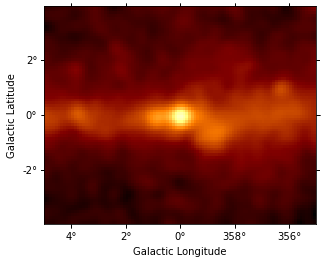

In [12]:
counts.sum_over_axes().smooth(2).plot(stretch="sqrt", vmax=30);

## Exposure

The Fermi-LAT dataset contains the energy-dependent exposure for the whole sky as a HEALPix map computed with ``gtexpcube2``. This format is supported by `~gammapy.maps` directly.

Interpolating the exposure cube from the Fermi ST to get an exposure cube matching the spatial geometry and energy axis defined above with Gammapy is easy. The only point to watch out for is how exactly you want the energy axis and binning handled.

Below we just use the default behaviour, which is linear interpolation in energy on the original exposure cube. Probably log interpolation would be better, but it doesn't matter much here, because the energy binning is fine. Finally, we just copy the counts map geometry, which contains an energy axis with `node_type="edges"`. This is non-ideal for exposure cubes, but again, acceptable because exposure doesn't vary much from bin to bin, so the exact way interpolation occurs in later use of that exposure cube doesn't matter a lot. Of course you could define any energy axis for your exposure cube that you like.

In [13]:
exposure_hpx = Map.read(
    "$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_exposure_cube_hpx.fits.gz"
)
print(exposure_hpx.geom)
print(exposure_hpx.geom.axes[0])

HpxGeom

	axes       : ['skycoord', 'energy_true']
	shape      : (49152, 18)
	ndim       : 3
	nside      : 64
	nested     : False
	frame      : icrs
	projection : HPX
	center     : 0.0 deg, 0.0 deg

MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 18        
	node type  : center    
	center min : 1.0e+04 MeV
	center max : 2.0e+06 MeV
	interp     : log       



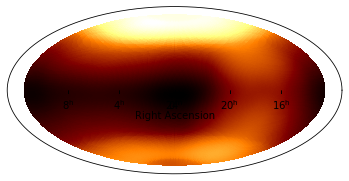

In [14]:
exposure_hpx.plot();

In [15]:
# For exposure, we choose a geometry with node_type='center',
# whereas for counts it was node_type='edge'
axis = MapAxis.from_energy_bounds(
    "10 GeV",
    "2 TeV",
    nbin=10,
    per_decade=True,
    name="energy_true",
)
geom = WcsGeom(wcs=counts.geom.wcs, npix=counts.geom.npix, axes=[axis])

exposure = exposure_hpx.interp_to_geom(geom)

In [16]:
counts.geom.axes[0]

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+04 MeV
	edges max  : 2.0e+06 MeV
	interp     : log       

In [17]:
print(exposure.geom)
print(exposure.geom.axes[0])

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (100, 80, 24)
	ndim       : 3
	frame      : galactic
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 8.0 deg
	wcs ref    : 0.0 deg, 0.0 deg

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 24        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 2.0e+00 TeV
	interp     : log       



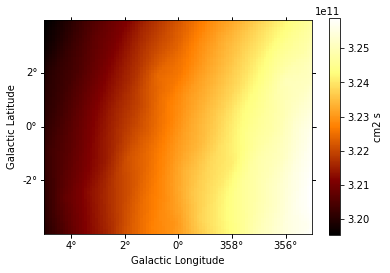

In [18]:
# Exposure is almost constant across the field of view
exposure.slice_by_idx({"energy_true": 0}).plot(add_cbar=True);

In [19]:
# Exposure varies very little with energy at these high energies
energy = [10, 100, 1000] * u.GeV
exposure.get_by_coord({"skycoord": gc_pos, "energy_true": energy})

array([3.22974080e+11, 3.29585273e+11, 2.90605275e+11])

## Galactic diffuse background

The Fermi-LAT collaboration provides a galactic diffuse emission model, that can be used as a background model for
Fermi-LAT source analysis.

Diffuse model maps are very large (100s of MB), so as an example here, we just load one that represents a small cutout for the Galactic center region.

In [20]:
diffuse_galactic_fermi = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)

# Unit is not stored in the file, set it manually
diffuse_galactic_fermi.unit = "cm-2 s-1 MeV-1 sr-1"
print(diffuse_galactic_fermi.geom)

print(diffuse_galactic_fermi.geom.axes[0])

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (120, 64, 30)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, -0.1 deg
	width      : 15.0 deg x 8.0 deg
	wcs ref    : 0.0 deg, 0.0 deg

MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 30        
	node type  : center    
	center min : 5.8e+01 MeV
	center max : 5.1e+05 MeV
	interp     : log       



In [21]:
template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)

In [22]:
diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)

Let's look at the map of first energy band of the cube:

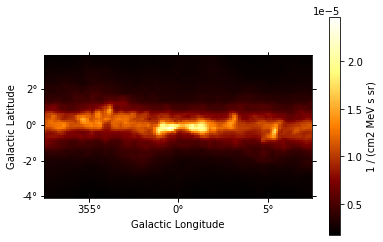

In [23]:
template_diffuse.map.slice_by_idx({"energy_true": 0}).plot(add_cbar=True);

Here is the spectrum at the Glaactic center:

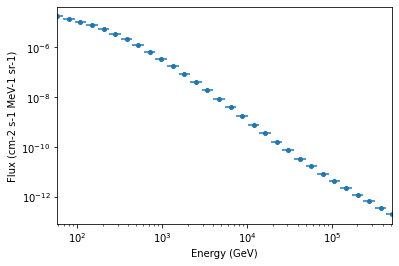

In [24]:
dnde = template_diffuse.map.to_region_nd_map(region=gc_pos)
dnde.plot()
plt.xlabel("Energy (GeV)")
plt.ylabel("Flux (cm-2 s-1 MeV-1 sr-1)");

## Isotropic diffuse background

To load the isotropic diffuse model with Gammapy, use the `~gammapy.modeling.models.TemplateSpectralModel`. We are using `'fill_value': 'extrapolate'` to extrapolate the model above 500 GeV:

In [25]:
filename = "$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt"

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename=filename, interp_kwargs={"fill_value": None}
)

We can plot the model in the energy range between 50 GeV and 2000 GeV:

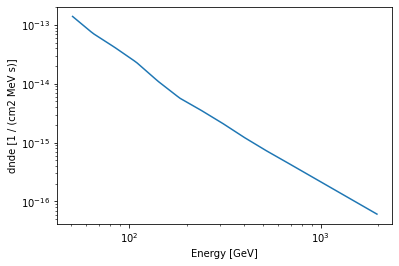

In [26]:
energy_bounds = [50, 2000] * u.GeV
diffuse_iso.spectral_model.plot(
    energy_bounds, yunits=u.Unit("1 / (cm2 MeV s)")
);

## PSF

Next we will tke a look at the PSF. It was computed using ``gtpsf``, in this case for the Galactic center position. Note that generally for Fermi-LAT, the PSF only varies little within a given regions of the sky, especially at high energies like what we have here. We use the `~gammapy.irf.PSFMap` class to load the PSF and use some of it's methods to get some information about it.

In [27]:
psf = PSFMap.read(
    "$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_psf_gc.fits.gz", format="gtpsf"
)
print(psf)

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (1, 1, 300, 17)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f8



To get an idea of the size of the PSF we check how the containment radii of the Fermi-LAT PSF vari with energy and different containment fractions:

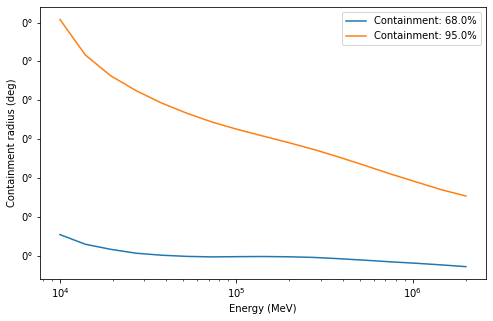

In [28]:
plt.figure(figsize=(8, 5))
psf.plot_containment_radius_vs_energy()
plt.show()

In addition we can check how the actual shape of the PSF varies with energy and compare it against the mean PSF between 50 GeV and 2000 GeV:

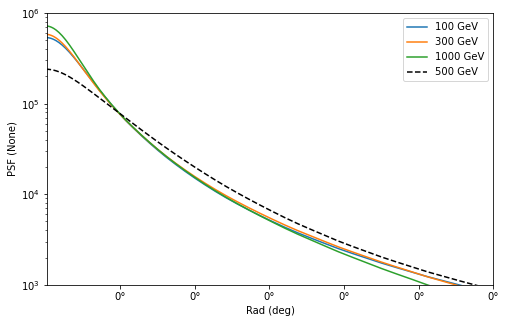

In [29]:
plt.figure(figsize=(8, 5))

energy = [100, 300, 1000] * u.GeV
psf.plot_psf_vs_rad(energy_true=energy)

spectrum = PowerLawSpectralModel(index=2.3)
psf_mean = psf.to_image(spectrum=spectrum)
psf_mean.plot_psf_vs_rad(c="k", ls="--", energy_true=[500] * u.GeV)

plt.xlim(1e-3, 0.3)
plt.ylim(1e3, 1e6)
plt.legend();

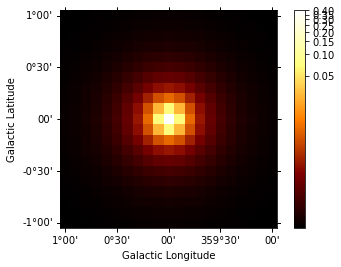

In [30]:
psf_kernel = psf.get_psf_kernel(
    position=geom.center_skydir, geom=geom, max_radius="1 deg"
)
psf_kernel.to_image().psf_kernel_map.plot(stretch="log", add_cbar=True);

### Energy Dispersion
For simplicity we assume a diagonal energy dispersion:

In [31]:
e_true = exposure.geom.axes["energy_true"]
edisp = EDispKernelMap.from_diagonal_response(
    energy_axis_true=e_true, energy_axis=energy_axis
)

<AxesSubplot:xlabel='Energy_true [TeV]', ylabel='Energy [MeV]'>

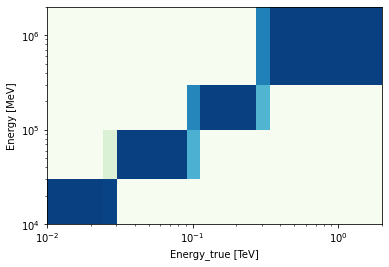

In [32]:
edisp.get_edisp_kernel().plot_matrix()

## Fit
Now, the big finale: let’s do a 3D map fit for the source at the Galactic center, to measure it’s position and spectrum. We keep the background normalization free.

In [33]:
spatial_model = PointSpatialModel(
    lon_0="0 deg", lat_0="0 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.7, amplitude="5.8e-10 cm-2 s-1 TeV-1", reference="100 GeV"
)

source = SkyModel(
    spectral_model=spectral_model,
    spatial_model=spatial_model,
    name="source-gc",
)

models = Models([source, diffuse_iem, diffuse_iso])

dataset = MapDataset(
    models=models, counts=counts, exposure=exposure, psf=psf, edisp=edisp
)

In [34]:
%%time
fit = Fit()
result = fit.run(datasets=[dataset])

CPU times: user 1.5 s, sys: 120 ms, total: 1.62 s
Wall time: 1.56 s


In [35]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 192
	total stat : 19666.08

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 192
	total stat : 19666.08




In [36]:
print(models)

Models

Component 0: SkyModel

  Name                      : source-gc
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.764   +/-    0.11             
    amplitude               :   5.20e-10   +/- 1.1e-10 1 / (cm2 s TeV)
    reference    (frozen)   :    100.000       GeV         
    lon_0                   :     -0.025   +/-    0.00 deg         
    lat_0                   :     -0.041   +/-    0.00 deg         

Component 1: SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                    :      0.975   +/-    0.01             
    tilt         (frozen)   :      0.000                   
    reference    (frozen)   :    

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


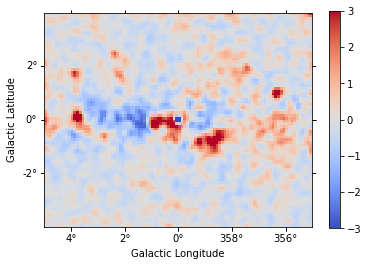

In [37]:
residual = counts - dataset.npred()
residual.sum_over_axes().smooth("0.1 deg").plot(
    cmap="coolwarm", vmin=-3, vmax=3, add_cbar=True
);

## Exercises

- Fit the position and spectrum of the source [SNR G0.9+0.1](http://gamma-sky.net/#/cat/tev/110).
- Make maps and fit the position and spectrum of the [Crab nebula](http://gamma-sky.net/#/cat/tev/25).

## Summary

In this tutorial you have seen how to work with Fermi-LAT data with Gammapy. You have to use the Fermi ST to prepare the exposure cube and PSF, and then you can use Gammapy for any event or map analysis using the same methods that are used to analyse IACT data.

This works very well at high energies (here above 10 GeV), where the exposure and PSF is almost constant spatially and only varies a little with energy. It is not expected to give good results for low-energy data, where the Fermi-LAT PSF is very large. If you are interested to help us validate down to what energy Fermi-LAT analysis with Gammapy works well (e.g. by re-computing results from 3FHL or other published analysis results), or to extend the Gammapy capabilities (e.g. to work with energy-dependent multi-resolution maps and PSF), that would be very welcome!